In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = \delta(x-y)
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain and $\delta(x-y)$ corresponds to a localised source term such can be a well in subsurface reservoirs.  

Our goal is to create params to solutions models, this time a mapping from y to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [5]:
from solvers.PoissonSolver import PoissonSolver
from config_step_2 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [6]:
def delta(y, x, dy = 1., dx = 0.) :
    """    
    y : int, float or ndarray of size 1
    x : ndarray
    
    return dy if x = y and dx otherwise
    """
    if torch.is_tensor(y):
        return torch.where(torch.isclose(torch.Tensor(x), y), dy, dx)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    return np.where(np.isclose(np.array(x), y), dy, dx)

In [7]:
PARAMS_SOLVER['source_term'] = lambda y, x: delta(y,x)
x = np.linspace(0., 1., 101)
PARAMS_SOLVER['F'] = delta(0.2, x)

In [8]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [9]:
u = solver.solve

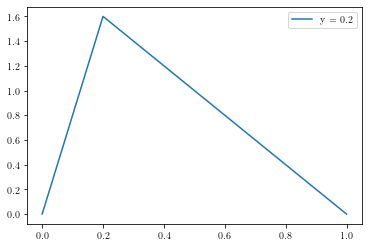

In [10]:
plt.plot(solver.x, u, label=f'y = {solver.x[np.where(solver.F == 1)][0]}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [11]:
# As we use a dirac, we need the values of y to correspond with the grid
Y_list = solver.x[20:81].reshape(-1, 1)

In [12]:
# From y position to F source term
VF = delta(Y_list, solver.x)
# Vectorized solver
VU = solver.Vsolve(vect = 'F', F = VF)

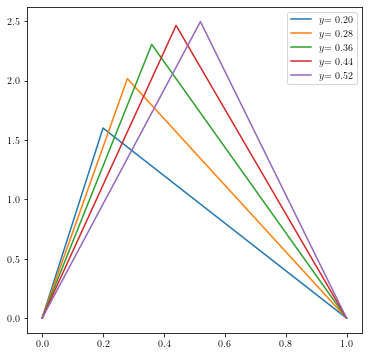

In [13]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in range(0, 40, 8):
    axs.plot(solver.x, VU[sample], label=f'$y$= {Y_list[sample, 0]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [14]:
from methods.DataDrivenMethods import DDMethod

In [15]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'PINN', 'MLPINN', 'DEEPONET', 'FNO']

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [16]:
from config_step_2 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [17]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 24, 28, 11, 18, 21, 1],
 'activations': 'tanh',
 'device': device(type='cuda'),
 'seed': 123}

Create DDMethod object for each method

In [18]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [19]:
Y_train, Y_val, U_train, U_val = sklearn.model_selection.train_test_split(Y_list, VU, test_size=0.2, random_state=123)

In [20]:
F_train = delta(Y_train, solver.x)
F_val = delta(Y_val, solver.x)

In [21]:
nx = PARAMS_SOLVER['nx']

### MLP, PINN

In [22]:
Y_train_repeated = torch.Tensor(Y_train.repeat(nx, 1)).view(-1, 1)
Y_val_repeated = torch.Tensor(Y_val.repeat(nx, 1)).view(-1, 1)

In [23]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(Y_train.shape[0], 1)
X_val = x.repeat(Y_val.shape[0], 1)

In [24]:
YX_train = torch.cat((Y_train_repeated, X_train), dim=1)
YX_val = torch.cat((Y_val_repeated, X_val), dim=1)
YU_train = torch.Tensor(U_train).view(-1, 1)
YU_val = torch.Tensor(U_val).view(-1, 1)

### FNO

In [25]:
F_fno_train = torch.Tensor(F_train).unsqueeze(-1)
F_fno_val = torch.Tensor(F_val).unsqueeze(-1)

Load models for Neural Networks, and fit for POD

In [26]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=VU)
    
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=YU_train, U_val=YU_val, 
                                DX_train=YX_train, DX_val=YX_val, 
                                data_ratio=1., physics_ratio=0.)
        
    elif method == 'PINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                DX_train=YX_train, DX_val=YX_val, 
                                U_train=YU_train, U_val=YU_val,
                                data_ratio=0., physics_ratio=1., loss='Y', w_r=11)    
    
    elif method == 'MLPINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                DX_train=YX_train, DX_val=YX_val, 
                                U_train=YU_train, U_val=YU_val, 
                                data_ratio=1., physics_ratio=1., loss='Y', w_r=11)
        
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=U_train, U_val=U_val, 
                                D_train=F_train, D_val=F_val)
        
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                D_train=F_fno_train, D_val=F_fno_val, 
                                U_train=U_train, U_val=U_val)

Fitting POD
POD fitted
Fitting MLP


[tr : 1.4e-05, val : 1.5e-05]: 100%|█████| 20000/20000 [00:41<00:00, 484.64it/s]


MLP fitted
Fitting PINN


[tr : 2.2e-04, val : 7.3e-02]: 100%|█████| 20000/20000 [01:01<00:00, 323.11it/s]


PINN fitted
Fitting MLPINN


[tr : 5.0e-05, val : 1.8e-05]: 100%|█████| 20000/20000 [01:49<00:00, 182.33it/s]


MLPINN fitted
Fitting DEEPONET


[tr : 1.5e-03, val : 1.5e-01]: 100%|█████| 20000/20000 [00:48<00:00, 409.39it/s]


DEEPONET fitted
Fitting FNO


[tr : 7.3e-07, val : 6.4e-07]: 100%|█████| 20000/20000 [01:40<00:00, 199.01it/s]

FNO fitted


MLP 1728
DEEPONET 2384129
PINN 754
MLPINN 1606
FNO 105632


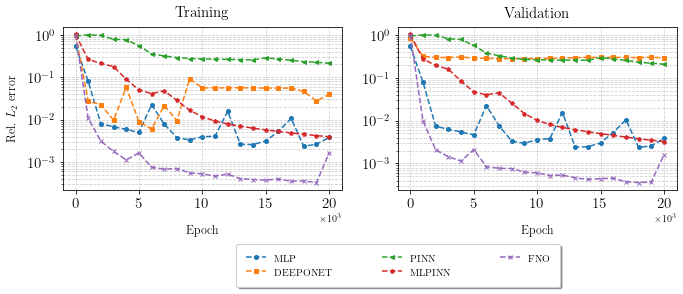

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3))

for mark, method in zip(['--o', '--s', '--<', '--p', '--x'], ['MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']):
    
    l2_err_train = all_methods[method]._method._l2_losses['train']
    l2_err_val = all_methods[method]._method._l2_losses['val']
    
    num_parameters = all_methods[method]._method.num_parameters()
    print(method, num_parameters)
    
    axs[0].plot(range(0, 20000, 999), l2_err_train[::999], mark, markersize=4, label = method)
    axs[1].plot(range(0, 20000, 999), l2_err_val[::999], mark, markersize=4, label = method)

axs[0].set_ylabel('Rel. $L_2$ error', size=12, labelpad = 10)
axs[0].set_title('Training', size = 15, pad = 10)
axs[1].set_title('Validation', size = 15, pad = 10)

for i in range(2):
    
    axs[i].grid(True, which='both', alpha = .6, ls='dashed')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Epoch', fontsize = 12, labelpad=15)
    
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    # axs[i].set_xlim(-500, 10500)
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(3, 3))

axs[0].legend(bbox_to_anchor=(1.8, -0.3), ncol=3, columnspacing = 5, shadow = True, borderpad = 1)
plt.savefig('l2_step_2.pdf', bbox_inches = 'tight')
plt.show()

# Plot performances for each method

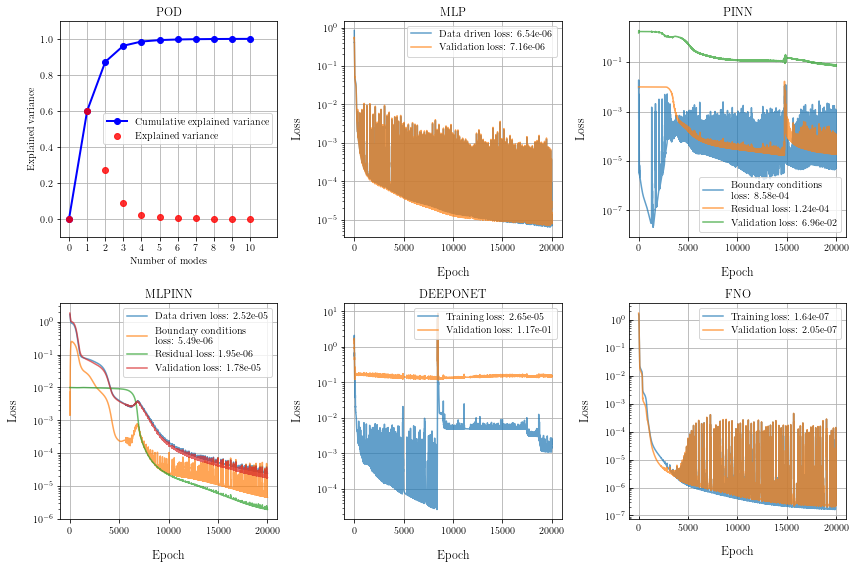

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
# plt.savefig("figs/step_2/fitting_step_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

## In distribution analysis

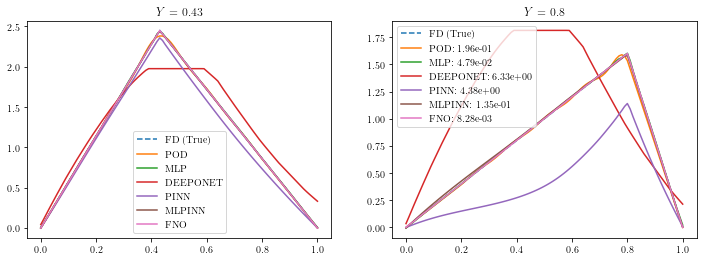

In [25]:
new_y = 0.43
new_F = delta(new_y, solver.x)
solver.change_F(F=new_F)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = [new_y], y = [new_y]).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}')
ax_0.title.set_text(f'$Y$ = {new_y}')
ax_0.legend()

new_OOD_y = 0.8
new_OOD_F = delta(new_OOD_y, solver.x)
solver.change_F(F=new_OOD_F)
U_FD = solver.solve

ax_1.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = [new_OOD_y], y = [new_OOD_y]).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}: {np.linalg.norm(U_pred - U_FD, 2):.2e}')
    

ax_1.title.set_text(f'$Y$ = {new_OOD_y}')
ax_1.legend()
plt.show()

## Parity plot

In [26]:
# #### IN DISTRIBUTION D GENERATION ######
Y_list = torch.Tensor(Y_list)
VU_list = torch.Tensor(np.stack(VU))

    
y_train, y_val, u_train, u_val = sklearn.model_selection.train_test_split(Y_list, VU_list, test_size=0.2, random_state=123)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

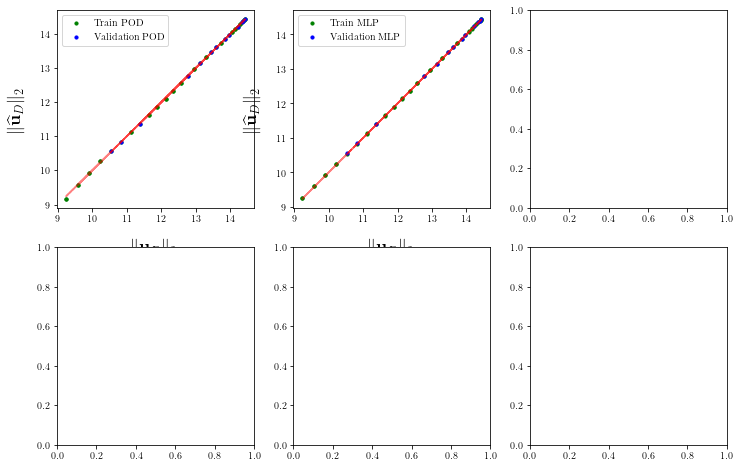

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    if method in ['POD', 'MLP', 'PINN', 'MLPINN', 'DEEPONET', 'FNO']:
        all_methods[method].parity_plot(U=u_train, phi=Y_train, Y=y_train, ax=ax, label=f'Train {method}', color='green')
        all_methods[method].parity_plot(U=u_val, phi=y_val, Y=y_val, ax=ax, label=f'Validation {method}', color='blue')
        ax.legend()
    
plt.tight_layout()
plt.show()

In [ ]:
#### OUT OF DISTRIBUTION Y GENERATION ######
OOD_Y = np.concatenate([np.linspace(0.1, 0.2, 41), np.linspace(0.8, 0.9, 41)]).reshape(-1, 1)
# From y position to F source term
OOD_VF = delta(OOD_Y, solver.x)
# Vectorized solver
OOD_VU = solver.Vsolve(vect = 'F', F = OOD_VF)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    
    all_methods[method].parity_plot(U=VU_list, phi = Y_list, Y=Y_list, ax=ax, label=f'ID {method}', color='green')
    all_methods[method].parity_plot(U=OOD_VU, phi= OOD_Y, Y=OOD_Y, ax=ax, label=f'OOD {method}', color='blue')
    ax.legend()
    
plt.tight_layout()
# plt.savefig("figs/step_2/ID_OOD_step_2.pdf", format="pdf", bbox_inches="tight")
plt.show()